# Data

In [1]:
train = read.csv("2019tae/train.csv")
test = read.csv("2019tae/test.csv")

# Stage 1: Cluster

## Process Corpus to DTM

In [1]:
if(!require(tm)){
  install.packages("tm")
  library(tm)
}

# Modify Stopwords
engstop = as.vector(stopwords("english"))

remove_ls = c("cannot","against","most","ought","aren't",
           "couldn't","hadn't","couldn't","not","than",
           "doesn't","until", "above","down" ,"over","only",
           "too","been","having","don't","while","below",
           "under","how","such","very","hasn't","can't",
           "out","all","more","no","same")
mod_stopwords = engstop [! engstop %in% remove_ls]
mod_stopwords

Loading required package: tm

Loading required package: NLP



[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "being"      "have"      
 [46] "has"        "had"        "do"         "does"       "did"       
 [51] "doing"      "would"      "should"     "could"      "i'm"       
 [56] "you're"     "he's"       "she's"      "it's"       "we're"     
 [61] "they're"    "i've"       "you've"     "we've"      "they've"   
 [66] "i'd"        "you'd"      "he'd"       "she'd"      "we'd"      
 [71] "they'd"     "i'll"       "you'll"     "he'll"      "she'll"    
 [76] "we'll"      "they'll"    "isn't"      "wasn't"     "weren't"   
 [81] "haven't"    "didn't"     "won't"      "wouldn't"   "shan't"    
 [86] "shouldn't"  "mustn't"    "let's"      "that's"     "who's"     
 [91] "what's"     "here's"     "there's"    "when's"     "where's"   
 [96] "why's"      "how's"      "a"          "an"         "the"       
[101] "and"        "but"        "if"         "or"         "because"   
[106] "as"         "of"         "at"         "by"         "for"       
[111] "with"       "about"      "between"    "into"       "through"   
[116] "during"     "before"     "after"      "to"         "from"      
[121] "up"         "in"         "on"         "off"        "again"     
[126] "further"    "then"       "once"       "here"       "there"     
[131] "when"       "where"      "why"        "any"        "both"      
[136] "each"       "few"        "other"      "some"       "nor"       
[141] "own"        "so"

In [3]:
# CHANGEME

corpus <- VCorpus(VectorSource(train$tweet))
corpus <- tm_map(corpus,content_transformer(tolower))
# corpus <- tm_map(corpus,removeWords,stopwords('english'))
corpus <- tm_map(corpus,removeWords,mod_stopwords)
corpus <- tm_map(corpus,removeWords,c("weather"))
corpus <- tm_map(corpus,removePunctuation)
corpus <- tm_map(corpus,removeNumbers)
corpus <- tm_map(corpus,stemDocument)

In [4]:
if(!require(RWeka)){
  install.packages("RWeka")
  library(RWeka)
  # We realised a little late that RWeka may have some Java dependencies >.<
  # Please note that we only used the function NGramTokenizer from RWeka
  # as a utility fn, not as part of the model.
  # in hindsight, we found several pure R packages which could achieve the same utility
  # e.g. https://www.rdocumentation.org/packages/tokenizers/versions/0.2.1/topics/ngram-tokenizers
  # we should have used this instead, but we didn't due to time constraints
  # apologies for the oversight; we seek your understanding to please permit this
  # the main bulk of the model is k means clustering and randomforest!
}

BigramTokenizer <- function(x) NGramTokenizer(x, Weka_control(min = 1, max = 2))
dtm <- DocumentTermMatrix(corpus, control = list(tokenize = BigramTokenizer))
dtm_sparsity = .97 # CHANGEME
dtm <- removeSparseTerms(dtm,dtm_sparsity)

twittersparse <- as.data.frame(as.matrix(dtm))
colnames(twittersparse) <- make.names(colnames(twittersparse))
twittersparse$sentiment = train$sentiment

In [5]:
length(findFreqTerms(dtm,lowfreq=50))
dtm

[1] 44

<<DocumentTermMatrix (documents: 22500, terms: 44)>>
Non-/sparse entries: 64724/925276
Sparsity           : 93%
Maximal term length: 18
Weighting          : term frequency (tf)

## Clean Test Data

In [6]:
# CHANGEME 
corpus <- VCorpus(VectorSource(test$tweet))
corpus <- tm_map(corpus,content_transformer(tolower))
# corpus <- tm_map(corpus,removeWords,stopwords('english'))
corpus <- tm_map(corpus,removeWords,mod_stopwords)
corpus <- tm_map(corpus,removeWords,c("weather"))
corpus <- tm_map(corpus,removePunctuation)
corpus <- tm_map(corpus,removeNumbers)
corpus <- tm_map(corpus,stemDocument)

In [7]:
dtm_test <- DocumentTermMatrix(corpus, control = list(tokenize = BigramTokenizer, dictionary=Terms(dtm)))
twittersparse_test <- as.data.frame(as.matrix(dtm_test))
colnames(twittersparse_test) <- make.names(colnames(twittersparse_test))


## Cluster

In [8]:
if(!require(caret)){
  install.packages("caret")
  library(caret)
}

limitedTrain = twittersparse
limitedTrain$sentiment = NULL
limitedTest = twittersparse_test
limitedTest$sentiment = NULL

preproc = preProcess(limitedTrain)
normTrain = predict(preproc, limitedTrain)
normTest = predict(preproc, limitedTest)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate




In [9]:
set.seed(1)
centers = 3
km = kmeans(normTrain, centers = centers , nstart = 5)

if(!require(flexclust)){
  install.packages("flexclust")
  library(flexclust)
}

km.kcca = as.kcca(km, normTrain)
clusterTrain = predict(km.kcca)
clusterTest = predict(km.kcca, newdata = normTest)
table(clusterTrain)

Loading required package: grid

Loading required package: modeltools

Loading required package: stats4



clusterTrain
    1     2     3 
 7395  1484 13621 

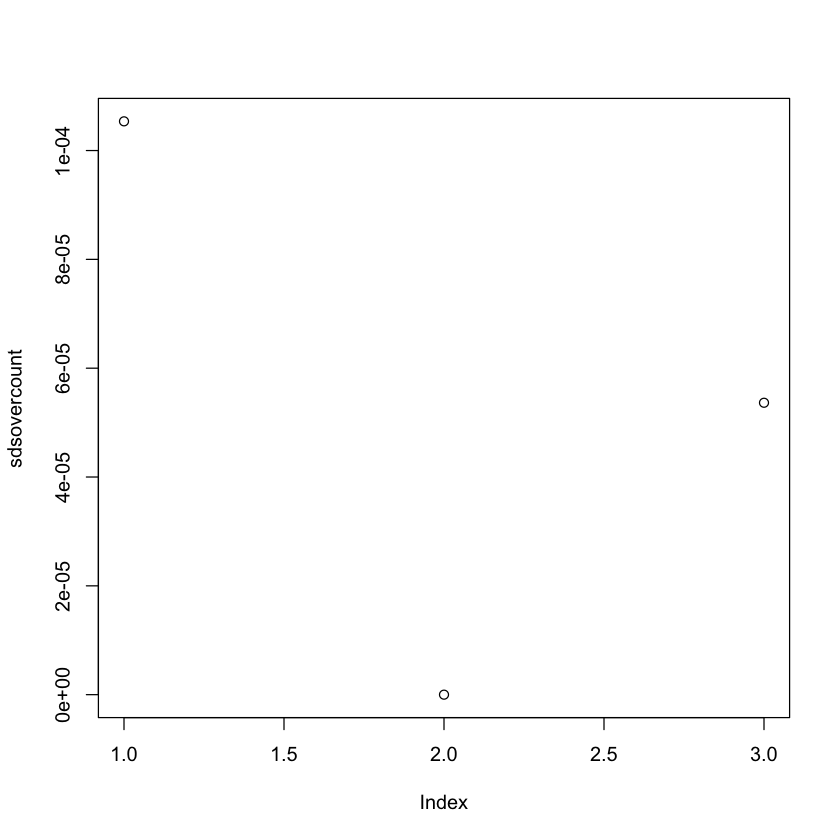

In [10]:
for (k in 1:centers) {
    name1 = paste0("train",k)
    value1 = subset(twittersparse, clusterTrain == k)
    assign(name1, value1)
    name2 = paste0("test",k)
    value2 = subset(twittersparse_test, clusterTest == k)
    assign(name2, value2)
}
sdsovercount = NULL
for (k in 1:centers) {
    sdsovercount = c(sdsovercount, sd(eval(parse(text = paste0("train",k,"$sentiment"))))/table(clusterTrain)[as.character(k)])
}
plot(sdsovercount) # gives us some insight into the 'purity' of clusters

# Stage 2: Random Forest

## Regenerate DTM

In [15]:
for (k in 1:centers) {
    name = paste0("train",k)
    val = train[as.numeric(rownames(eval(parse(text = name)))),]
    rownames(val) = rownames(eval(parse(text = name)))
    assign(name, val)
    
    name = paste0("test",k)
    val = test[as.numeric(rownames(eval(parse(text = name)))),]
    rownames(val) = rownames(eval(parse(text = name)))
    assign(name, val)
}

In [17]:

for (k in 1:centers) {
    # CHANGEME
    name = paste0("train",k)
    corpus <- VCorpus(VectorSource(eval(parse(text = name))$tweet))
    corpus <- tm_map(corpus,content_transformer(tolower))
    # STOPWORDS
    # corpus <- tm_map(corpus,removeWords,stopwords('english'))
    corpus <- tm_map(corpus,removeWords,mod_stopwords)
    # STOPWORDS
    corpus <- tm_map(corpus,removePunctuation)
    corpus <- tm_map(corpus,removeNumbers)
    corpus <- tm_map(corpus,stemDocument)

    BigramTokenizer <- function(x) NGramTokenizer(x, Weka_control(min = 1, max = 2))
    dtm <- DocumentTermMatrix(corpus, control = list(tokenize = BigramTokenizer))
    dtm_sparsity = 0.999 # CHANGEME
    dtm <- removeSparseTerms(dtm,dtm_sparsity)

    twittersparse <- as.data.frame(as.matrix(dtm))
    colnames(twittersparse) <- make.names(colnames(twittersparse))
    twittersparse$sentiment = eval(parse(text = name))$sentiment
    assign(name, twittersparse)
   
    # CHANGEME
    name = paste0("test",k)
    corpus <- VCorpus(VectorSource(eval(parse(text = name))$tweet))
    corpus <- tm_map(corpus,content_transformer(tolower))
    # STOPWORDS
    # corpus <- tm_map(corpus,removeWords,stopwords('english'))
    corpus <- tm_map(corpus,removeWords,mod_stopwords)
    # STOPWORDS
    corpus <- tm_map(corpus,removePunctuation)
    corpus <- tm_map(corpus,removeNumbers)
    corpus <- tm_map(corpus,stemDocument)

    dtm_test <- DocumentTermMatrix(corpus, control = list(tokenize = BigramTokenizer, dictionary=Terms(dtm)))
    twittersparse_test <- as.data.frame(as.matrix(dtm_test))
    colnames(twittersparse_test) <- make.names(colnames(twittersparse_test))
    rownames(twittersparse_test) = rownames(eval(parse(text = name)))
    twittersparse$sentiment = test$sentiment
    assign(name, twittersparse_test)
    
}

In [18]:
# head(sort(apply(train4,2,sum), decreasing = TRUE), 20) 

# Train Model

In [19]:
if(!require(randomForest)){
  install.packages("randomForest")
  library(randomForest)
}

# CHANGEME
set.seed(1)
ntree = 500
nodesize = 10

for (k in 1:centers) {
    if (sd(eval(parse(text = paste0("train",k,"$sentiment")))) != 0) {
        dataname = paste0("train",k)
        forestname = paste0("forest",k)

        forest = randomForest(as.factor(sentiment)~., data=eval(parse(text = dataname)), nodesize=nodesize, ntree=ntree)
        assign(forestname, forest)        
    }

}

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [20]:
# train[as.numeric(rownames(train20)),]

# Predictions

In [21]:
for (k in 1:centers) {
    dataname = paste0("test",k)
    predname = paste0("predict",k)
    if (sd(eval(parse(text = paste0("train",k,"$sentiment")))) != 0) {
        forestname = paste0("forest",k)
        prediction <- predict(eval(parse(text = forestname)),newdata=eval(parse(text = dataname)),type="class")
        assign(predname, prediction)
    } else {
        n = dim(eval(parse(text = dataname)))[1]
        guess = mean(eval(parse(text = paste0("train",k,"$sentiment"))))
        prediction = rep(guess, n)
        names = rownames(eval(parse(text = dataname)))
        names(prediction) = names
        assign(predname, prediction)
    }
}

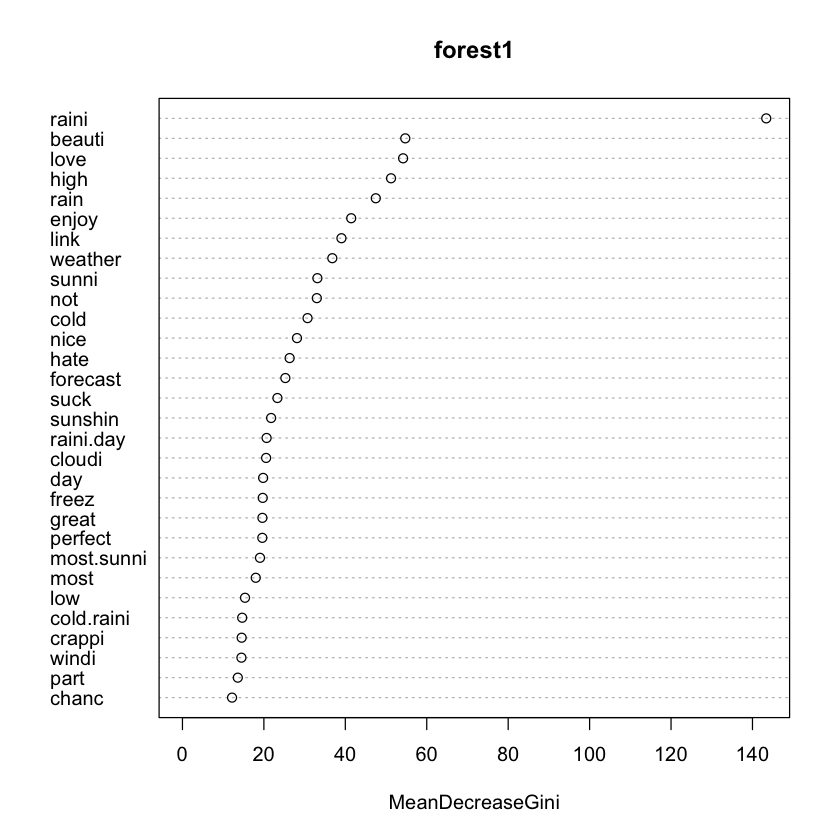

In [22]:
varImpPlot(forest1)
# 1,4,5,6,7

In [23]:
predicts = NULL
for (k in 1:centers) {
    predname = paste0("predict",k)
    predicts = c(predicts, eval(parse(text = predname)))
}
predicts <- predicts[ order(as.numeric(names(predicts))) ]

In [24]:
results = subset(test, select=-c(tweet))
results$sentiment = predicts

# Export csv

In [26]:
write.csv(results, file = "submission_k1_1_3_500XXX.csv",row.names=FALSE)